In [7]:
import asyncio
import csv
import json
from typing import Any, Dict, List, Optional, Set
from playwright.async_api import async_playwright

def deep_find_keys(node: Any, targets: Set[str], found: Dict[str, Any]) -> None:
    """Depth-first search that records first occurrence of each key in `targets`."""
    if not (targets - set(found.keys())):
        return
    if isinstance(node, dict):
        for k, v in node.items():
            if k in targets and k not in found:
                found[k] = v
            deep_find_keys(v, targets, found)
    elif isinstance(node, list):
        for v in node:
            deep_find_keys(v, targets, found)

def get_in(obj: Any, path: List[str], default=None):
    cur = obj
    for k in path:
        if isinstance(cur, dict) and k in cur:
            cur = cur[k]
        else:
            return default
    return cur

def full_name(entry: dict) -> Optional[str]:
    given = get_in(entry, ["playerStats","player","playerName","givenName"])
    sur   = get_in(entry, ["playerStats","player","playerName","surname"])
    if given or sur:
        return " ".join([x for x in [given, sur] if x]).strip()
    # fallbacks
    given = get_in(entry, ["player","player","playerName","givenName"])
    sur   = get_in(entry, ["player","player","playerName","surname"])
    if given or sur:
        return " ".join([x for x in [given, sur] if x]).strip()
    nm = get_in(entry, ["playerStats","player","playerName"]) or get_in(entry, ["player","player","playerName"])
    return str(nm).strip() if nm else None

def flatten_row(entry: dict, side_label: str) -> dict:
    stats = get_in(entry, ["playerStats", "stats"], {}) or {}
    ext   = stats.get("extendedStats") or {}
    cl    = stats.get("clearances") or {}

    row = {
        "name": full_name(entry),
        "number": get_in(entry, ["player", "jumperNumber"]),
        "position": get_in(entry, ["player", "player", "position"]),
        "playerId": get_in(entry, ["playerStats", "player", "playerId"]) \
                    or get_in(entry, ["player","player","playerId"]),
        "teamId": entry.get("teamId") or get_in(entry, ["playerStats","teamId"]),
        "teamSide": side_label,

        # core box score
        "goals": stats.get("goals"),
        "behinds": stats.get("behinds"),
        "kicks": stats.get("kicks"),
        "handballs": stats.get("handballs"),
        "disposals": stats.get("disposals"),
        "marks": stats.get("marks"),
        "hitouts": stats.get("hitouts"),
        "tackles": stats.get("tackles"),

        # clearances
        "centreClearances": cl.get("centreClearances"),
        "stoppageClearances": cl.get("stoppageClearances"),
        "totalClearances": cl.get("totalClearances"),

        # i50 / r50
        "inside50s": stats.get("inside50s"),
        "rebound50s": stats.get("rebound50s"),

        # frees
        "freesFor": stats.get("freesFor"),
        "freesAgainst": stats.get("freesAgainst"),

        # possessions
        "contestedPossessions": stats.get("contestedPossessions"),
        "uncontestedPossessions": stats.get("uncontestedPossessions"),

        # metres/meters gained
        "metresGained": stats.get("metresGained") if "metresGained" in stats else stats.get("metersGained"),

        # extras often present
        "marksInside50": stats.get("marksInside50"),
        "contestedMarks": stats.get("contestedMarks"),
        "onePercenters": stats.get("onePercenters"),
        "bounces": stats.get("bounces"),
        "intercepts": stats.get("intercepts"),
        "turnovers": stats.get("turnovers"),
        "scoreInvolvements": stats.get("scoreInvolvements"),
        "goalAssists": stats.get("goalAssists"),
        "shotsAtGoal": stats.get("shotsAtGoal"),

        # efficiency & fantasy
        "disposalEfficiency": stats.get("disposalEfficiency"),
        "dreamTeamPoints": stats.get("dreamTeamPoints"),
        "ratingPoints": stats.get("ratingPoints"),

        # TOG & update time
        "timeOnGroundPercentage": get_in(entry, ["playerStats","timeOnGroundPercentage"]),
        "rowLastUpdated": get_in(entry, ["playerStats","lastUpdated"]),
    }

    for k in ("effectiveKicks","kickEfficiency","kickToHandballRatio","effectiveDisposals"):
        if k in ext:
            row[k] = ext[k]
    return row

def write_csv(rows: List[dict], path: str):
    base_cols = [
        "name","number","position","playerId","teamId","teamSide",
        "goals","behinds","kicks","handballs","disposals","marks","hitouts","tackles",
        "centreClearances","stoppageClearances","totalClearances",
        "inside50s","rebound50s",
        "freesFor","freesAgainst",
        "contestedPossessions","uncontestedPossessions",
        "marksInside50","contestedMarks","onePercenters","bounces","intercepts","turnovers",
        "scoreInvolvements","goalAssists","shotsAtGoal",
        "disposalEfficiency","metresGained","dreamTeamPoints","ratingPoints",
        "timeOnGroundPercentage","rowLastUpdated",
        "effectiveKicks","kickEfficiency","kickToHandballRatio","effectiveDisposals",
    ]
    dyn = []
    for r in rows:
        for k in r.keys():
            if k not in base_cols and k not in dyn:
                dyn.append(k)
    cols = base_cols + dyn
    with open(path, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=cols)
        w.writeheader()
        for r in rows:
            w.writerow({k: r.get(k, "") for k in cols})

async def scrape_match_to_csv(url: str, base: Optional[str] = None):
    """Scrape AFL Match Centre URL and write 3 CSVs."""
    if base is None:
        tail = url.rstrip("/").split("/")[-1] or "afl_match"
        base = f"match{tail}" if tail.isdigit() else tail

    captured: List[Any] = []
    async with async_playwright() as pw:
        browser = await pw.chromium.launch(headless=True)
        context = await browser.new_context(
            user_agent=(
                "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                "(KHTML, like Gecko) Chrome/124 Safari/537.36"
            ),
            locale="en-AU",
        )
        page = await context.new_page()

        async def grab(resp):
            try:
                ct = (resp.headers or {}).get("content-type", "")
                rtype = resp.request.resource_type
                if ("application/json" in ct.lower()) or (rtype in ("xhr","fetch")):
                    txt = await resp.text()
                    if txt:
                        try:
                            captured.append(json.loads(txt))
                        except Exception:
                            pass
            except Exception:
                pass

        page.on("response", lambda resp: asyncio.create_task(grab(resp)))
        await page.goto(url, wait_until="domcontentloaded", timeout=60_000)
        try:
            await page.wait_for_load_state("networkidle", timeout=30_000)
        except Exception:
            pass
        await asyncio.sleep(5)

        targets = {"homeTeamPlayerStats", "awayTeamPlayerStats"}
        found: Dict[str, Any] = {}
        for blob in captured:
            deep_find_keys(blob, targets, found)
            if targets.issubset(found.keys()):
                break

        home = found.get("homeTeamPlayerStats") or []
        away = found.get("awayTeamPlayerStats") or []

        home_rows = [flatten_row(x, "home") for x in home]
        away_rows = [flatten_row(x, "away") for x in away]
        all_rows  = home_rows + away_rows

        home_csv = f"{base}_homeTeamPlayerStats.csv"
        away_csv = f"{base}_awayTeamPlayerStats.csv"
        all_csv  = f"{base}_allPlayers.csv"

        write_csv(home_rows, home_csv)
        write_csv(away_rows, away_csv)
        write_csv(all_rows,  all_csv)

        await browser.close()

    print({"homeCount": len(home_rows), "awayCount": len(away_rows), "csv": [home_csv, away_csv, all_csv]})


In [8]:
URL = "https://www.afl.com.au/afl/matches/7150"
BASE = "match7150"  # filenames will start with this


In [9]:
await scrape_match_to_csv(URL, base=BASE)


/opt/anaconda3/lib/python3.12/collections/__init__.py:447: RuntimeWarning: coroutine 'scrape_match_to_csv' was never awaited
  @classmethod


Error: BrowserType.launch: Executable doesn't exist at /Users/user/Library/Caches/ms-playwright/chromium_headless_shell-1181/chrome-mac/headless_shell
╔════════════════════════════════════════════════════════════╗
║ Looks like Playwright was just installed or updated.       ║
║ Please run the following command to download new browsers: ║
║                                                            ║
║     playwright install                                     ║
║                                                            ║
║ <3 Playwright Team                                         ║
╚════════════════════════════════════════════════════════════╝

In [12]:
# ONE-CELL NOTEBOOK: Scrape AFL Match Centre (7150) and export player stats to CSVs

# --- Install deps into the current Jupyter kernel and fetch Chromium ---
import sys, subprocess, asyncio, csv, json, os
from typing import Any, Dict, List, Optional, Set

def _sh(*args):
    try:
        subprocess.run(args, check=True)
    except Exception as e:
        print("Command failed (continuing):", " ".join(args), "\n", e)

_sh(sys.executable, "-m", "pip", "install", "-q", "playwright", "pandas")
_sh(sys.executable, "-m", "playwright", "install", "chromium")

# --- Imports after install ---
import pandas as pd
from playwright.async_api import async_playwright

# --- Utils ---
def deep_find_keys(node: Any, targets: Set[str], found: Dict[str, Any]) -> None:
    """DFS that records the first occurrence of each key in `targets`."""
    if not (targets - set(found.keys())):
        return
    if isinstance(node, dict):
        for k, v in node.items():
            if k in targets and k not in found:
                found[k] = v
            deep_find_keys(v, targets, found)
    elif isinstance(node, list):
        for v in node:
            deep_find_keys(v, targets, found)

def get_in(obj: Any, path: List[str], default=None):
    cur = obj
    for k in path:
        if isinstance(cur, dict) and k in cur:
            cur = cur[k]
        else:
            return default
    return cur

def full_name(entry: dict) -> Optional[str]:
    given = get_in(entry, ["playerStats","player","playerName","givenName"])
    sur   = get_in(entry, ["playerStats","player","playerName","surname"])
    if given or sur:
        return " ".join([x for x in [given, sur] if x]).strip()
    # fallbacks
    given = get_in(entry, ["player","player","playerName","givenName"])
    sur   = get_in(entry, ["player","player","playerName","surname"])
    if given or sur:
        return " ".join([x for x in [given, sur] if x]).strip()
    nm = get_in(entry, ["playerStats","player","playerName"]) or get_in(entry, ["player","player","playerName"])
    return str(nm).strip() if nm else None

def flatten_row(entry: dict, side_label: str) -> dict:
    stats = get_in(entry, ["playerStats", "stats"], {}) or {}
    ext   = stats.get("extendedStats") or {}
    cl    = stats.get("clearances") or {}

    row = {
        "name": full_name(entry),
        "number": get_in(entry, ["player", "jumperNumber"]),
        "position": get_in(entry, ["player", "player", "position"]),
        "playerId": get_in(entry, ["playerStats", "player", "playerId"]) \
                    or get_in(entry, ["player","player","playerId"]),
        "teamId": entry.get("teamId") or get_in(entry, ["playerStats","teamId"]),
        "teamSide": side_label,

        # core box score
        "goals": stats.get("goals"),
        "behinds": stats.get("behinds"),
        "kicks": stats.get("kicks"),
        "handballs": stats.get("handballs"),
        "disposals": stats.get("disposals"),
        "marks": stats.get("marks"),
        "hitouts": stats.get("hitouts"),
        "tackles": stats.get("tackles"),

        # clearances
        "centreClearances": cl.get("centreClearances"),
        "stoppageClearances": cl.get("stoppageClearances"),
        "totalClearances": cl.get("totalClearances"),

        # i50 / r50
        "inside50s": stats.get("inside50s"),
        "rebound50s": stats.get("rebound50s"),

        # frees
        "freesFor": stats.get("freesFor"),
        "freesAgainst": stats.get("freesAgainst"),

        # possessions
        "contestedPossessions": stats.get("contestedPossessions"),
        "uncontestedPossessions": stats.get("uncontestedPossessions"),

        # metres/meters gained
        "metresGained": stats.get("metresGained") if "metresGained" in stats else stats.get("metersGained"),

        # extras often present
        "marksInside50": stats.get("marksInside50"),
        "contestedMarks": stats.get("contestedMarks"),
        "onePercenters": stats.get("onePercenters"),
        "bounces": stats.get("bounces"),
        "intercepts": stats.get("intercepts"),
        "turnovers": stats.get("turnovers"),
        "scoreInvolvements": stats.get("scoreInvolvements"),
        "goalAssists": stats.get("goalAssists"),
        "shotsAtGoal": stats.get("shotsAtGoal"),

        # efficiency & fantasy
        "disposalEfficiency": stats.get("disposalEfficiency"),
        "dreamTeamPoints": stats.get("dreamTeamPoints"),
        "ratingPoints": stats.get("ratingPoints"),

        # TOG & update time
        "timeOnGroundPercentage": get_in(entry, ["playerStats","timeOnGroundPercentage"]),
        "rowLastUpdated": get_in(entry, ["playerStats","lastUpdated"]),
    }
    for k in ("effectiveKicks","kickEfficiency","kickToHandballRatio","effectiveDisposals"):
        if k in ext:
            row[k] = ext[k]
    return row

def write_csv(rows: List[dict], path: str):
    base_cols = [
        "name","number","position","playerId","teamId","teamSide",
        "goals","behinds","kicks","handballs","disposals","marks","hitouts","tackles",
        "centreClearances","stoppageClearances","totalClearances",
        "inside50s","rebound50s",
        "freesFor","freesAgainst",
        "contestedPossessions","uncontestedPossessions",
        "marksInside50","contestedMarks","onePercenters","bounces","intercepts","turnovers",
        "scoreInvolvements","goalAssists","shotsAtGoal",
        "disposalEfficiency","metresGained","dreamTeamPoints","ratingPoints",
        "timeOnGroundPercentage","rowLastUpdated",
        "effectiveKicks","kickEfficiency","kickToHandballRatio","effectiveDisposals",
    ]
    dyn = []
    for r in rows:
        for k in r.keys():
            if k not in base_cols and k not in dyn:
                dyn.append(k)
    cols = base_cols + dyn
    with open(path, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=cols)
        w.writeheader()
        for r in rows:
            w.writerow({k: r.get(k, "") for k in cols})

# --- Async scraper (works in Jupyter) ---
async def scrape_match_to_csv(url: str, base: Optional[str] = None):
    if base is None:
        tail = url.rstrip("/").split("/")[-1] or "afl_match"
        base = f"match{tail}" if tail.isdigit() else tail

    captured: List[Any] = []

    async with async_playwright() as pw:
        browser = await pw.chromium.launch(headless=True)
        context = await browser.new_context(
            user_agent=(
                "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                "(KHTML, like Gecko) Chrome/124 Safari/537.36"
            ),
            locale="en-AU",
        )
        page = await context.new_page()

        async def grab(resp):
            try:
                ct = (resp.headers or {}).get("content-type", "")
                rtype = resp.request.resource_type
                if ("application/json" in ct.lower()) or (rtype in ("xhr","fetch")):
                    txt = await resp.text()
                    if txt:
                        try:
                            captured.append(json.loads(txt))
                        except Exception:
                            pass
            except Exception:
                pass

        page.on("response", lambda resp: asyncio.create_task(grab(resp)))

        await page.goto(url, wait_until="domcontentloaded", timeout=60_000)
        try:
            await page.wait_for_load_state("networkidle", timeout=30_000)
        except Exception:
            pass
        await asyncio.sleep(5)

        targets = {"homeTeamPlayerStats", "awayTeamPlayerStats"}
        found: Dict[str, Any] = {}
        for blob in captured:
            deep_find_keys(blob, targets, found)
            if targets.issubset(found.keys()):
                break

        home = found.get("homeTeamPlayerStats") or []
        away = found.get("awayTeamPlayerStats") or []

        home_rows = [flatten_row(x, "home") for x in home]
        away_rows = [flatten_row(x, "away") for x in away]
        all_rows  = home_rows + away_rows

        home_csv = f"/Users/user/{base}_homeTeamPlayerStats.csv"
        away_csv = f"/Users/user/{base}_awayTeamPlayerStats.csv"
        all_csv  = f"/Users/user/{base}_allPlayers.csv"

        write_csv(home_rows, home_csv)
        write_csv(away_rows, away_csv)
        write_csv(all_rows,  all_csv)

        await browser.close()

    return {"homeCount": len(home_rows), "awayCount": len(away_rows), "csv": [home_csv, away_csv, all_csv]}

# --- Configure & RUN (supports top-level await in Jupyter) ---
URL  = "https://www.afl.com.au/afl/matches/7150"
BASE = "match7150"

# If the notebook already has an event loop, just await; otherwise try to run it.
try:
    loop = asyncio.get_running_loop()
    # Running loop (Jupyter) -> use top-level await
    result = await scrape_match_to_csv(URL, base=BASE)  # type: ignore  # top-level await is supported in IPython
except RuntimeError:
    # No running loop (plain Python) -> run normally
    result = asyncio.run(scrape_match_to_csv(URL, base=BASE))

print("Done:", result)

# --- Quick preview ---
for p in result["csv"]:
    if os.path.exists(p):
        print("Saved:", p)

if os.path.exists(f"/Users/user/{BASE}_allPlayers.csv"):
    df = pd.read_csv(f"/Users/user/{BASE}_allPlayers.csv")
    display(df.head(10))
    display(df.groupby("teamSide").size().to_frame("players"))


You are using a frozen ffmpeg browser which does not receive updates anymore on mac12. Please update to the latest version of your operating system to test up-to-date browsers.
Done: {'homeCount': 23, 'awayCount': 23, 'csv': ['/Users/user/match7150_homeTeamPlayerStats.csv', '/Users/user/match7150_awayTeamPlayerStats.csv', '/Users/user/match7150_allPlayers.csv']}
Saved: /Users/user/match7150_homeTeamPlayerStats.csv
Saved: /Users/user/match7150_awayTeamPlayerStats.csv
Saved: /Users/user/match7150_allPlayers.csv


,name,number,position,playerId,teamId,teamSide,goals,behinds,kicks,handballs,...,disposalEfficiency,metresGained,dreamTeamPoints,ratingPoints,timeOnGroundPercentage,rowLastUpdated,effectiveKicks,kickEfficiency,kickToHandballRatio,effectiveDisposals
0,Karl Amon,10,WR,CD_I297354,CD_T80,home,0.0,0.0,15.0,12.0,...,96.3,353.0,98.0,10.1,83.0,2025-08-07T12:22:27.011+0000,15.0,100.0,1.3,26.0
1,Tom Barrass,37,FB,CD_I990290,CD_T80,home,0.0,0.0,6.0,2.0,...,100.0,128.0,29.0,6.4,86.0,2025-08-07T12:22:27.011+0000,6.0,100.0,3.0,8.0
2,Josh Battle,24,BPL,CD_I998134,CD_T80,home,0.0,1.0,19.0,7.0,...,80.8,464.0,91.0,11.8,92.0,2025-08-07T12:22:27.011+0000,14.0,73.7,2.7,21.0
3,Luke Breust,22,SUB,CD_I280744,CD_T80,home,0.0,1.0,3.0,1.0,...,75.0,59.0,19.0,-1.0,26.0,2025-08-07T12:22:27.011+0000,2.0,66.7,3.0,3.0
4,Mabior Chol,18,CHF,CD_I994077,CD_T80,home,3.0,2.0,10.0,4.0,...,64.3,220.0,88.0,11.1,75.0,2025-08-07T12:22:27.011+0000,5.0,50.0,2.5,9.0
5,Massimo D'Ambrosio,16,WL,CD_I1005144,CD_T80,home,0.0,0.0,13.0,11.0,...,83.3,289.0,84.0,9.3,80.0,2025-08-07T12:22:27.011+0000,9.0,69.2,1.2,20.0
6,Calsher Dear,35,INT,CD_I1032100,CD_T80,home,1.0,2.0,5.0,3.0,...,50.0,115.0,36.0,2.5,56.0,2025-08-07T12:22:27.011+0000,1.0,20.0,1.7,4.0
7,Jack Ginnivan,33,FPL,CD_I1012857,CD_T80,home,0.0,0.0,13.0,13.0,...,57.7,311.0,78.0,8.5,84.0,2025-08-07T12:22:27.011+0000,5.0,38.5,1.0,15.0
8,Jack Gunston,19,HFFL,CD_I291351,CD_T80,home,4.0,0.0,8.0,3.0,...,81.8,215.0,77.0,12.0,85.0,2025-08-07T12:22:27.011+0000,6.0,75.0,2.7,9.0
9,Blake Hardwick,15,BPR,CD_I993794,CD_T80,home,0.0,0.0,7.0,4.0,...,81.8,123.0,41.0,8.1,89.0,2025-08-07T12:22:27.011+0000,5.0,71.4,1.8,9.0


,players
teamSide,
away,23
home,23


In [2]:
# ONE-CELL: AFL matchPlays -> gather ALL event lists, flatten, dedupe, sort, and export

import json, csv, os, re, requests, hashlib
from typing import Any, Dict, Iterable, List, Tuple, Set

TOKEN_URL = "https://api.afl.com.au/cfs/afl/WMCTok"
URL       = "https://sapi.afl.com.au/afl/matchPlays/CD_M20250142207"
BASE      = "CD_M20250142207"  # adjust if you want different filenames

# ---------------- Token + HTTP ----------------
def get_afl_token(timeout: float = 15.0) -> str:
    r = requests.post(TOKEN_URL, timeout=timeout)
    r.raise_for_status()
    tok = r.json().get("token")
    if not tok:
        raise RuntimeError("No 'token' in WMCTok response")
    return tok

def fetch_json_with_token(url: str, token: str, timeout: float = 30.0) -> Any:
    headers = {
        "Accept": "application/json, text/plain, */*",
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124 Safari/537.36",
        "x-media-mis-token": token,
        "Origin": "https://www.afl.com.au",
        "Referer": "https://www.afl.com.au/",
    }
    r = requests.get(url, headers=headers, timeout=timeout)
    if r.status_code == 401:
        raise RuntimeError("401 Unauthorized: token expired/invalid. Re-run this cell to refresh.")
    r.raise_for_status()
    return r.json()

# ---------------- JSON traversal ----------------
def _iter_nodes_with_path(root: Any, path: str = "$") -> Iterable[Tuple[str, Any]]:
    yield path, root
    if isinstance(root, dict):
        for k, v in root.items():
            if isinstance(v, (dict, list)):
                yield from _iter_nodes_with_path(v, f"{path}.{k}")
    elif isinstance(root, list):
        for i, v in enumerate(root):
            if isinstance(v, (dict, list)):
                yield from _iter_nodes_with_path(v, f"{path}[{i}]")

def _eventish_score(d: Dict[str, Any]) -> int:
    # Simple heuristic to decide if a dict looks like a play/event
    keys = " ".join(map(str, d.keys())).lower()
    score = 0
    for hint in ("period", "quarter", "qtr", "time", "display", "type", "event", "team", "player", "x", "y", "score"):
        if hint in keys:
            score += 1
    return score

def collect_event_lists(root: Any) -> List[Tuple[str, List[Dict[str, Any]]]]:
    """Return [(jsonpath, list_of_event_dicts)] for every list that looks like events."""
    found: List[Tuple[str, List[Dict[str, Any]]]] = []
    for p, node in _iter_nodes_with_path(root):
        if isinstance(node, list) and node and isinstance(node[0], dict):
            # score by first few items
            sample = node[:5]
            avg = sum(_eventish_score(x) for x in sample) / len(sample)
            if avg >= 2:  # threshold
                found.append((p, node))
    # Prefer direct keys if present by moving them to front
    priority = (".$.plays", ".$.matchPlays", ".$.events", ".$.data")
    def rank(item):
        p, _ = item
        return 0 if any(p.endswith(k[1:]) for k in priority) else 1
    found.sort(key=rank)
    return found

# ---------------- Flattening / Sorting / Dedup ----------------
def flatten_dict(d: Dict[str, Any], parent: str = "", sep: str = ".") -> Dict[str, Any]:
    out: Dict[str, Any] = {}
    for k, v in d.items():
        nk = f"{parent}{sep}{k}" if parent else k
        if isinstance(v, dict):
            out.update(flatten_dict(v, nk, sep))
        elif isinstance(v, list):
            # Keep list-of-dicts as JSON to avoid column explosion
            if v and all(isinstance(x, dict) for x in v):
                out[nk] = json.dumps(v, ensure_ascii=False)
            else:
                out[nk] = "|".join(map(str, v))
        else:
            out[nk] = v
    return out

def fingerprint_event(e: Dict[str, Any]) -> str:
    # Use a stable fingerprint: prefer 'id' if present, else hash of canonical JSON
    if "id" in e and isinstance(e["id"], (int, str)):
        return f"id::{e['id']}"
    canon = json.dumps(e, ensure_ascii=False, sort_keys=True, separators=(",", ":"))
    return "sha1::" + hashlib.sha1(canon.encode("utf-8")).hexdigest()

def parse_mmss(s: str) -> float:
    # returns seconds; tolerant of "MM:SS", "M:SS", and possibly "SS"
    if not isinstance(s, str): return float("inf")
    m = re.match(r"^(\d{1,2}):(\d{2})$", s.strip())
    if m:
        return int(m.group(1)) * 60 + int(m.group(2))
    try:
        return float(s)
    except Exception:
        return float("inf")

def row_period(flat: Dict[str, Any]) -> int:
    for k in ("period.number", "quarter", "qtr", "period"):
        v = flat.get(k)
        if isinstance(v, int): return v
        if isinstance(v, str) and v.isdigit(): return int(v)
    return 0

def row_seconds(flat: Dict[str, Any]) -> float:
    # Prefer explicit seconds remaining; else parse display time
    for k in ("period.secondsRemaining", "secondsRemaining", "seconds", "timeSeconds"):
        v = flat.get(k)
        if isinstance(v, (int, float)): return float(v)
        if isinstance(v, str) and v.isdigit(): return float(v)
    for k in ("displayTime", "period.displayTime", "time", "clock"):
        v = flat.get(k)
        if v is not None:
            return parse_mmss(str(v))
    return float("inf")

def choose_columns(flat_rows: List[Dict[str, Any]]) -> List[str]:
    preferred = [
        "id",
        "period","period.number","quarter","qtr",
        "displayTime","period.displayTime","time","clock","period.secondsRemaining",
        "type","eventType","playType","subType","result","outcome",
        "x","y","position.x","position.y",
        "teamId","team.id","team.abbrev","team.name",
        "playerId","player.id","player.name","player.playerName.givenName","player.playerName.surname",
        "homeScore","awayScore","score","scoreValue",
        "_sourcePath"
    ]
    all_keys = set()
    for r in flat_rows:
        all_keys.update(r.keys())
    ordered = [k for k in preferred if k in all_keys]
    remaining = sorted(all_keys - set(ordered))
    return ordered + remaining

def write_csv(rows: List[Dict[str, Any]], path: str) -> None:
    if not rows:
        open(path, "w", encoding="utf-8").close()
        return
    cols = choose_columns(rows)
    with open(path, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=cols, extrasaction="ignore")
        w.writeheader()
        for r in rows:
            w.writerow({c: r.get(c, "") for c in cols})

def write_ndjson(rows: List[Dict[str, Any]], path: str) -> None:
    with open(path, "w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

# ---------------- Run ----------------
token = get_afl_token()
data  = fetch_json_with_token(URL, token)

# Save raw
raw_path = f"{BASE}_raw.json"
with open(raw_path, "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

# Find ALL event-like lists
lists = collect_event_lists(data)
print("Event-like lists found:")
for p, arr in lists:
    print(f" - {p} : {len(arr)} rows")

# If there's an obvious primary (e.g., $.plays), keep it too
primary_csv_path = None
if lists:
    primary_path, primary_list = lists[0]
    primary_flat = []
    for ev in primary_list:
        flat = flatten_dict(ev)
        flat["_sourcePath"] = primary_path
        primary_flat.append(flat)
    primary_csv_path = f"{BASE}_plays.csv"
    write_csv(primary_flat, primary_csv_path)

# Build ALL rows (union of every list), dedupe, sort
seen = set()
all_flat: List[Dict[str, Any]] = []
for p, arr in lists:
    for ev in arr:
        fp = fingerprint_event(ev)
        if fp in seen:
            continue
        seen.add(fp)
        flat = flatten_dict(ev)
        flat["_sourcePath"] = p
        all_flat.append(flat)

# Sort best-effort by period then time within period
all_flat.sort(key=lambda r: (row_period(r), row_seconds(r)))

# Write outputs
all_csv  = f"{BASE}_plays_all.csv"
all_json = f"{BASE}_plays_all.ndjson"
write_csv(all_flat, all_csv)
write_ndjson([e for _, arr in lists for e in arr], all_json)

print("\nWrote:")
print(" ", raw_path)
if primary_csv_path:
    print(" ", primary_csv_path, "(primary list only)")
print(" ", all_csv, "(ALL lists merged, deduped, sorted)")
print(" ", all_json, "(ALL events NDJSON)")

# Optional preview (needs pandas)
try:
    import pandas as pd
    print("\nPreview of ALL events:")
    display(pd.read_csv(all_csv).head(12))
except Exception:
    pass


Event-like lists found:
 - $.matchChains : 209 rows
 - $.matchChains[0].stats : 7 rows
 - $.matchChains[1].stats : 6 rows
 - $.matchChains[2].stats : 7 rows
 - $.matchChains[3].stats : 13 rows
 - $.matchChains[4].stats : 4 rows
 - $.matchChains[5].stats : 5 rows
 - $.matchChains[6].stats : 7 rows
 - $.matchChains[7].stats : 4 rows
 - $.matchChains[8].stats : 3 rows
 - $.matchChains[9].stats : 4 rows
 - $.matchChains[10].stats : 17 rows
 - $.matchChains[11].stats : 1 rows
 - $.matchChains[12].stats : 1 rows
 - $.matchChains[13].stats : 3 rows
 - $.matchChains[14].stats : 9 rows
 - $.matchChains[15].stats : 11 rows
 - $.matchChains[16].stats : 7 rows
 - $.matchChains[17].stats : 21 rows
 - $.matchChains[18].stats : 8 rows
 - $.matchChains[19].stats : 25 rows
 - $.matchChains[20].stats : 7 rows
 - $.matchChains[21].stats : 37 rows
 - $.matchChains[22].stats : 13 rows
 - $.matchChains[23].stats : 8 rows
 - $.matchChains[24].stats : 5 rows
 - $.matchChains[25].stats : 5 rows
 - $.matchChain

,period,x,y,teamId,playerId,_sourcePath,behindInfo,description,displayOrder,disposal,finalState,initialState,periodSeconds,shotAtGoal,stats
0,NaN,0.0,0.0,NaN,NaN,$.matchChains[0].stats,NaN,Centre Bounce,1.0,NaN,NaN,NaN,0,NaN,NaN
1,NaN,7.0,9.0,CD_T40,CD_I1005054,$.matchChains[0].stats,NaN,Contested Knock On,2.0,NaN,NaN,NaN,7,NaN,NaN
2,NaN,15.0,12.0,CD_T40,CD_I994185,$.matchChains[0].stats,NaN,Gather,3.0,NaN,NaN,NaN,9,NaN,NaN
3,NaN,14.0,8.0,CD_T40,CD_I994185,$.matchChains[0].stats,NaN,Handball,4.0,effective,NaN,NaN,9,NaN,NaN
4,NaN,11.0,2.0,CD_T40,CD_I260257,$.matchChains[0].stats,NaN,Handball Received,5.0,NaN,NaN,NaN,11,NaN,NaN
5,NaN,13.0,-1.0,CD_T40,CD_I260257,$.matchChains[0].stats,NaN,Kick,6.0,ineffective,NaN,NaN,14,NaN,NaN
6,NaN,46.0,-40.0,NaN,NaN,$.matchChains[0].stats,NaN,Ball Up Call,7.0,NaN,NaN,NaN,22,NaN,NaN
7,NaN,-48.0,41.0,CD_T80,CD_I1002222,$.matchChains[1].stats,NaN,Gather From Hitout,8.0,NaN,NaN,NaN,33,NaN,NaN
8,NaN,-53.0,38.0,CD_T80,CD_I998390,$.matchChains[1].stats,NaN,Loose Ball Get,9.0,NaN,NaN,NaN,41,NaN,NaN
9,NaN,-52.0,38.0,CD_T80,CD_I998390,$.matchChains[1].stats,NaN,Kick,10.0,ineffective,NaN,NaN,42,NaN,NaN


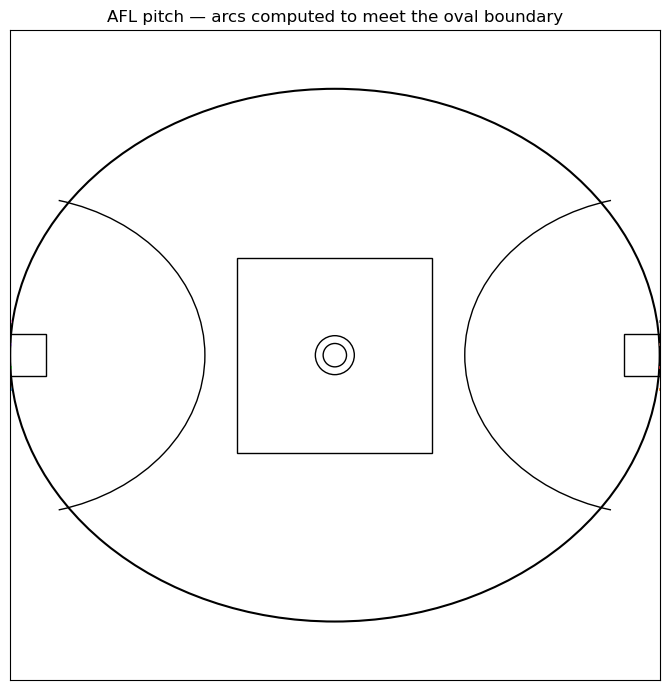

In [11]:
# AFL pitch (original coordinate system) where the forward arcs
# EXACTLY meet the oval boundary.
#
# x: 0..100 (goal to goal)
# y: -50..50 (wing to wing)
#
# We compute the two endpoints of each forward arc by solving the
# intersection between:
#   - the boundary oval   : ((x-50)/50)^2 + (y/(H/2))^2 = 1
#   - a goal arc ellipse  : ((x-cx)/rx)^2 + (y/ry)^2     = 1
# Then we pass those angles to matplotlib.patches.Arc.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle, Arc, Circle

# ---- look/feel (all in raw units; keep your data coords unchanged) ----
OVAL_HEIGHT = 82.0      # oval height in raw y-units
CENTER_SQ   = 30.0
R_OUT       = 3.0
R_IN        = 1.8
GS_DEPTH    = 5.5
GS_HALFWID  = 3.2

# goal arcs: radii in raw units (x/y radii for the ellipse centred at each goal)
ARC_RX      = 30.0
ARC_RY      = ARC_RX * (OVAL_HEIGHT / 100.0)

POST_X_OFF  = 2.5
POST_GAP    = 3.5

# ---- helpers ------------------------------------------------------------

def boundary_val(x, y, H=OVAL_HEIGHT):
    """Value of the boundary ellipse implicit equation; =0 on boundary."""
    return ((x - 50.0)/50.0)**2 + (y/(H/2.0))**2 - 1.0

def goal_arc_point(cx, rx, ry, t):
    """Parametric point on a goal arc ellipse centered at (cx,0)."""
    return cx + rx*np.cos(t), ry*np.sin(t)

def find_theta_intersections(cx, rx, ry, t_lo, t_hi, steps=720, tol=1e-10, max_iter=60):
    """
    Find all t in [t_lo, t_hi] where the goal arc ellipse intersects the boundary.
    Returns a sorted list of angles (radians).
    """
    ts = np.linspace(t_lo, t_hi, steps+1)
    vals = []
    for t in ts:
        x, y = goal_arc_point(cx, rx, ry, t)
        vals.append(boundary_val(x, y))
    vals = np.asarray(vals)

    # locate sign changes
    roots = []
    for i in range(steps):
        v0, v1 = vals[i], vals[i+1]
        if v0 == 0:
            roots.append(ts[i])
            continue
        if v0*v1 < 0:
            a, b = ts[i], ts[i+1]
            fa, fb = v0, v1
            # bisection
            for _ in range(max_iter):
                m = 0.5*(a+b)
                xm, ym = goal_arc_point(cx, rx, ry, m)
                fm = boundary_val(xm, ym)
                if abs(fm) < tol:
                    a = b = m
                    break
                if fa*fm <= 0:
                    b, fb = m, fm
                else:
                    a, fa = m, fm
            roots.append(0.5*(a+b))

    # dedupe close roots
    roots = sorted(roots)
    dedup = []
    for r in roots:
        if not dedup or abs(r - dedup[-1]) > 1e-3:
            dedup.append(r)
    return dedup

def draw_forward_arc_that_meets_boundary(ax, cx, rx, ry, side="left"):
    """
    Draw the forward arc centred at (cx,0) so that its ends meet the boundary.
    side: "left" (cx≈0) or "right" (cx≈100) only affects the search interval.
    """
    if side == "left":
        # around t ≈ 0 (pointing to the right)
        thetas = find_theta_intersections(cx, rx, ry, -np.pi/2, np.pi/2)
    else:
        # around t ≈ pi (pointing to the left)
        thetas = find_theta_intersections(cx, rx, ry, np.pi/2, 3*np.pi/2)

    if len(thetas) >= 2:
        t1, t2 = thetas[0], thetas[-1]
        # Matplotlib Arc uses degrees
        ax.add_patch(Arc((cx, 0), width=2*rx, height=2*ry, angle=0,
                         theta1=np.degrees(t1), theta2=np.degrees(t2),
                         linewidth=1, fill=False))
    else:
        # Fallback (should rarely happen): small fixed arc
        if side == "left":
            ax.add_patch(Arc((cx, 0), width=2*rx, height=2*ry, angle=0,
                             theta1=-35, theta2=35, linewidth=1, fill=False))
        else:
            ax.add_patch(Arc((cx, 0), width=2*rx, height=2*ry, angle=0,
                             theta1=145, theta2=215, linewidth=1, fill=False))

def draw_afl_pitch(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 7))

    # Boundary oval
    ax.add_patch(Ellipse((50, 0), width=100, height=OVAL_HEIGHT, fill=False, linewidth=1.5))

    # 50m-style arcs that *touch* the boundary
    draw_forward_arc_that_meets_boundary(ax, cx=0.0,   rx=ARC_RX, ry=ARC_RY, side="left")
    draw_forward_arc_that_meets_boundary(ax, cx=100.0, rx=ARC_RX, ry=ARC_RY, side="right")

    # Centre square & circles
    ax.add_patch(Rectangle((50 - CENTER_SQ/2, -CENTER_SQ/2), CENTER_SQ, CENTER_SQ,
                           fill=False, linewidth=1))
    ax.add_patch(Circle((50, 0), radius=R_OUT, fill=False, linewidth=1))
    ax.add_patch(Circle((50, 0), radius=R_IN,  fill=False, linewidth=1))

    # Goal squares
    ax.add_patch(Rectangle((0, -GS_HALFWID), GS_DEPTH, 2*GS_HALFWID, fill=False, linewidth=1))
    ax.add_patch(Rectangle((100 - GS_DEPTH, -GS_HALFWID), GS_DEPTH, 2*GS_HALFWID, fill=False, linewidth=1))

    # Goal/behind posts outside the lines (B G G B)
    base_y = -1.5 * POST_GAP
    for i in range(4):
        y = base_y + i * POST_GAP
        ax.plot([-POST_X_OFF, 0], [y, y], linewidth=2)
        ax.plot([100, 100 + POST_X_OFF], [y, y], linewidth=2)

    # Axes (original units), no ticks
    ax.set_xlim(0, 100)
    ax.set_ylim(-50, 50)
    ax.set_aspect("equal", "box")
    ax.set_xticks([]); ax.set_yticks([])
    ax.grid(False)
    return ax

# Demo
if __name__ == "__main__":
    ax = draw_afl_pitch()
    ax.set_title("AFL pitch — arcs computed to meet the oval boundary")
    plt.tight_layout()
    plt.savefig("afl_pitch_arcs_touch_boundary.png", dpi=150)
    plt.show()


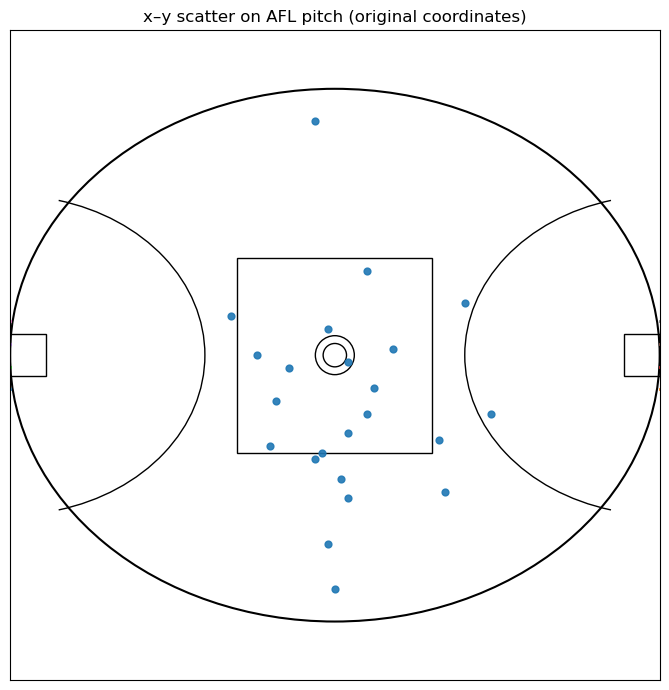

Saved -> goals_xy_scatter.png | points plotted: 23


In [15]:
# Scatter ANY x,y points on an AFL pitch (original coordinates).
# - Draws an oval pitch where the forward arcs exactly meet the boundary.
# - Overlays a scatter from a CSV (choose which columns to use).
#
# x range: 0..100  (goal line to goal line)
# y range: -50..50 (wing to wing)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle, Arc, Circle

# ---------- Pitch drawing (no conversions) ----------

OVAL_HEIGHT = 82.0      # oval height in raw y-units
CENTER_SQ   = 30.0
R_OUT       = 3.0
R_IN        = 1.8
GS_DEPTH    = 5.5
GS_HALFWID  = 3.2

ARC_RX      = 30.0
ARC_RY      = ARC_RX * (OVAL_HEIGHT / 100.0)

POST_X_OFF  = 2.5
POST_GAP    = 3.5

def boundary_val(x, y, H=OVAL_HEIGHT):
    """=0 on the oval boundary (ellipse centered at (50,0), width=100, height=H)."""
    return ((x - 50.0)/50.0)**2 + (y/(H/2.0))**2 - 1.0

def goal_arc_point(cx, rx, ry, t):
    """Parametric point on a goal arc ellipse centered at (cx,0)."""
    return cx + rx*np.cos(t), ry*np.sin(t)

def find_theta_intersections(cx, rx, ry, t_lo, t_hi, steps=720, tol=1e-10, max_iter=60):
    """Angles where the arc meets the boundary ellipse."""
    ts = np.linspace(t_lo, t_hi, steps+1)
    vals = []
    for t in ts:
        x, y = goal_arc_point(cx, rx, ry, t)
        vals.append(boundary_val(x, y))
    vals = np.asarray(vals)
    roots = []
    for i in range(steps):
        v0, v1 = vals[i], vals[i+1]
        if v0 == 0:
            roots.append(ts[i]); continue
        if v0*v1 < 0:
            a, b = ts[i], ts[i+1]
            fa, fb = v0, v1
            for _ in range(max_iter):
                m = 0.5*(a+b)
                xm, ym = goal_arc_point(cx, rx, ry, m)
                fm = boundary_val(xm, ym)
                if abs(fm) < tol:
                    a = b = m
                    break
                if fa*fm <= 0:
                    b, fb = m, fm
                else:
                    a, fa = m, fm
            roots.append(0.5*(a+b))
    roots.sort()
    dedup = []
    for r in roots:
        if not dedup or abs(r - dedup[-1]) > 1e-3:
            dedup.append(r)
    return dedup

def draw_forward_arc(ax, cx, rx, ry, side):
    if side == "left":
        thetas = find_theta_intersections(cx, rx, ry, -np.pi/2, np.pi/2)
    else:
        thetas = find_theta_intersections(cx, rx, ry,  np.pi/2, 3*np.pi/2)
    if len(thetas) >= 2:
        t1, t2 = thetas[0], thetas[-1]
        ax.add_patch(Arc((cx, 0), width=2*rx, height=2*ry, angle=0,
                         theta1=np.degrees(t1), theta2=np.degrees(t2),
                         linewidth=1, fill=False))
    else:
        # small fallback arc
        a1, a2 = (-35, 35) if side == "left" else (145, 215)
        ax.add_patch(Arc((cx, 0), width=2*rx, height=2*ry, angle=0,
                         theta1=a1, theta2=a2, linewidth=1, fill=False))

def draw_afl_pitch(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 7))

    # Boundary
    ax.add_patch(Ellipse((50, 0), width=100, height=OVAL_HEIGHT, fill=False, linewidth=1.5))

    # Arcs that touch the boundary
    draw_forward_arc(ax, cx=0.0,   rx=ARC_RX, ry=ARC_RY, side="left")
    draw_forward_arc(ax, cx=100.0, rx=ARC_RX, ry=ARC_RY, side="right")

    # Centre square & circles
    ax.add_patch(Rectangle((50 - CENTER_SQ/2, -CENTER_SQ/2), CENTER_SQ, CENTER_SQ, fill=False, linewidth=1))
    ax.add_patch(Circle((50, 0), radius=R_OUT, fill=False, linewidth=1))
    ax.add_patch(Circle((50, 0), radius=R_IN,  fill=False, linewidth=1))

    # Goal squares
    ax.add_patch(Rectangle((0, -GS_HALFWID), GS_DEPTH, 2*GS_HALFWID, fill=False, linewidth=1))
    ax.add_patch(Rectangle((100 - GS_DEPTH, -GS_HALFWID), GS_DEPTH, 2*GS_HALFWID, fill=False, linewidth=1))

    # Goal/behind posts (B G G B)
    base_y = -1.5 * POST_GAP
    for i in range(4):
        y = base_y + i * POST_GAP
        ax.plot([-POST_X_OFF, 0], [y, y], linewidth=2)
        ax.plot([100, 100 + POST_X_OFF], [y, y], linewidth=2)

    ax.set_xlim(0, 100)
    ax.set_ylim(-50, 50)
    ax.set_aspect("equal", "box")
    ax.set_xticks([]); ax.set_yticks([]); ax.grid(False)
    return ax

# ---------- Scatter overlay from CSV ----------

def pitch_scatter_from_csv(csv_path,
                           x_col="x", y_col="y",
                           filter_col=None, filter_value=None,
                           s=24, alpha=0.9, marker="o",
                           out_png="afl_xy_scatter.png"):
    """
    Overlay a scatter on the pitch using original CSV coordinates.
    - filter_col/filter_value: optional exact-match filter (e.g., description == 'Goal')
    """
    df = pd.read_csv(csv_path)
    if filter_col is not None and filter_col in df.columns:
        df = df[df[filter_col].astype(str) == str(filter_value)]

    x = pd.to_numeric(df[x_col], errors="coerce")
    y = pd.to_numeric(df[y_col], errors="coerce")
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]

    ax = draw_afl_pitch()
    ax.scatter(x, y, s=s, alpha=alpha, marker=marker)
    ax.set_title("x–y scatter on AFL pitch (original coordinates)")

    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()
    print(f"Saved -> {out_png} | points plotted: {len(x)}")

# --------- Example usage ---------
pitch_scatter_from_csv(
    "CD_M20250142207_plays_all.csv",
    x_col="x", y_col="y",
     filter_col="description", filter_value="Goal",
     out_png="goals_xy_scatter.png"
 )
